## packages

In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [26]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl

from sklearn.linear_model import LinearRegression

## funciones

In [27]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [28]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [29]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [30]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [31]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [32]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [33]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=10, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [34]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

# Importar y arreglar datos

In [35]:
feb16 = xr.open_dataset("data/adcp2012feb.nc")
newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")

In [36]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

In [37]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [38]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [39]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [40]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [41]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [42]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [43]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

## Densidad

In [44]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [45]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [46]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [47]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

# Second breach

In [48]:
bu2 = UV_burst.sel(time=slice("2012-02-23","2012-03-04")).u
wdf = dfw['u'].loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
sf = snfco.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
mt = mnty.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
dc1 = DC_1.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
dc2 = DC_2.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
dc3 = DC_3.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
dc4 = DC_4.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]

nm1 = NM_1.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
nm2 = NM_2.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
nm3 = NM_3.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]

ml1 = ML_1.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]
ml2 = ML_2.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]

pc1 = PC_1.loc[datetime.date(2012,2,23):datetime.date(2012,3,4)]

y_bin = np.linspace(1.19, 3.59, 25)

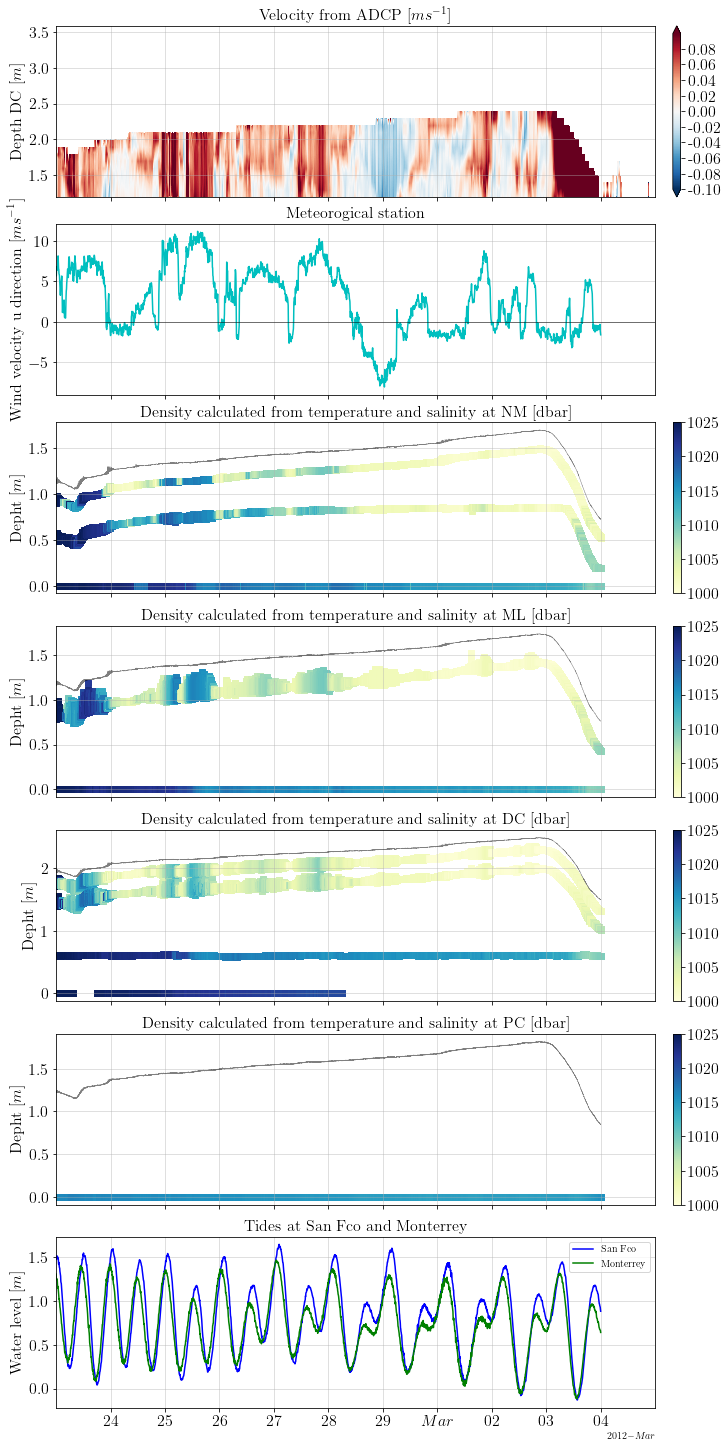

In [67]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 20), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico densidades PC

ax6.set_title(r"Density calculated from temperature and salinity at PC [$kg/m^3$]",
          fontsize=16)
ax6.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(pc1.index, pc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax6.scatter(pc1.index, pc1['Depth'].values-pc1['Depth'].values, c=pc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar5 = fig.colorbar(scat, ax=ax6, pad=0.03)
cbar5.ax.tick_params(labelsize=16)
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right');
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## 23-Mar

In [25]:
bu2 = UV_burst.sel(time=slice("2012-02-23 00:00:00","2012-02-24 00:00:00")).u
wdf = dfw['u'].loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
sf = snfco.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
mt = mnty.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc1 = DC_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc2 = DC_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc3 = DC_3.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
dc4 = DC_4.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

nm1 = NM_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
nm2 = NM_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
nm3 = NM_3.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

ml1 = ML_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]
ml2 = ML_2.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

pc1 = PC_1.loc[datetime.date(2012,2,23):datetime.date(2012,2,24)]

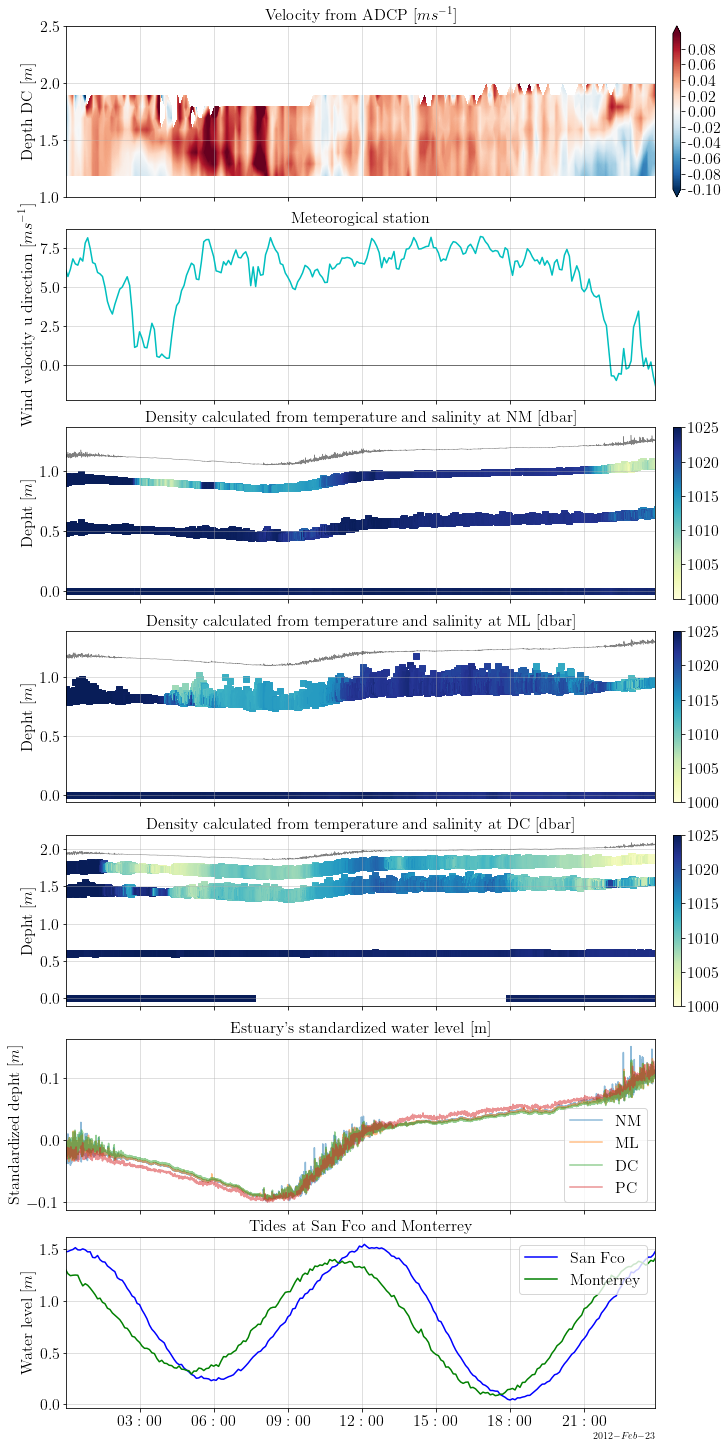

In [88]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax1, ax2, ax4, ax5, ax3, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 20), constrained_layout=True, sharex=True)


#Grafico de velocidad del agua (color map)
ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
          fontsize=16)
contourf_ = ax1.contourf(bu2.time, y_bin,
                         np.transpose(bu2.values),
                         levels=level_boundaries_u,
                         cmap=cm.RdBu_r,
                         vmax=umax, vmin=umin, extend='both')
cbar = fig.colorbar(contourf_, ax=ax1, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax1.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.grid(alpha=0.5)
ax1.set_ylim(1, 2.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

#Grafico velocidad viento

ax2.set_title(r"Meteorogical station",
          fontsize=16)
ax2.set_ylabel(r"Wind velocity u direction "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax2.plot(wdf.index, -wdf.values,color='c')
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de profundidad y densidad (color map) DC
ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
          fontsize=16)
ax3.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax3.scatter(dc1.index, dc1['Depth']-dc1['Depth'], c=dc1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc2.index, dc1['Depth'].values-dc2['Depth'].values, c=dc2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc3.index, dc1['Depth'].values-dc3['Depth'].values, c=dc3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(dc4.index, dc1['Depth'].values-dc4['Depth'].values, c=dc4['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.03)
cbar2.ax.tick_params(labelsize=16)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

# Grafico densidades NM

ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
          fontsize=16)
ax4.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax4.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax4.scatter(nm1.index, nm1['Depth'].values-nm1['Depth'].values, c=nm1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm2.index, nm1.loc[nm3.index]['Depth'].values-nm2['Depth'].values, c=nm2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(nm3.index, nm1.loc[nm3.index]['Depth'].values-nm3['Depth'].values, c=nm3['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.03)
cbar3.ax.tick_params(labelsize=16)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

# Grafico densidades ML

ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
          fontsize=16)
ax5.set_ylabel(r"Depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax5.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
scat = ax5.scatter(ml1.index, ml1['Depth'].values-ml1['Depth'].values, c=ml1['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(ml2.index, ml1['Depth'].values-ml2['Depth'].values, c=ml2['densidad'], marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.03)
cbar4.ax.tick_params(labelsize=16)
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)

# Grafico water level estandarizada

ax6.set_title(r"Estuary's standardized water level [m]",
          fontsize=16)
ax6.set_ylabel(r"Standardized depht "
          r"$\displaystyle[m]$",
          fontsize=16)
ax6.plot(nm1.index, nm1['Depth']-nm1['Depth'].mean(), alpha=0.5)
ax6.plot(ml1.index, ml1['Depth']-ml1['Depth'].mean(), alpha=0.5)
ax6.plot(dc1.index, dc1['Depth']-dc1['Depth'].mean(), alpha=0.5)
ax6.plot(pc1.index, pc1['Depth']-pc1['Depth'].mean(), alpha=0.5)
ax6.legend(["NM", "ML", "DC", "PC"], loc='lower right',
          fontsize=16);
ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)

# Grafico nivel del agua SF

ax7.set_title(r"Tides at San Fco and Monterrey",
          fontsize=16)
ax7.set_ylabel(r"Water level "
          r"$\displaystyle[m]$",
          fontsize=16)
ax7.plot(sf.index, sf.values, c='b')
ax7.plot(mt.index, mt.values, c='g')
ax7.legend(["San Fco", "Monterrey"], loc='upper right',
          fontsize=16);
ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

- La boca comienza a cerrarse
- Se observa que existe wave overtopping cuando la marea aumenta, ya que la densidad en la superficie aumenta
- Marea domina le movimiento dentro del estuario
- Cuando baja la marea se observa que el estuario se estratifica y cuando sube vuelve a mezclarse

<ipython-input-26-d3c3d6bce874>:54: RuntimeWarning: divide by zero encountered in reciprocal
  return (x * 60) ** (-1)


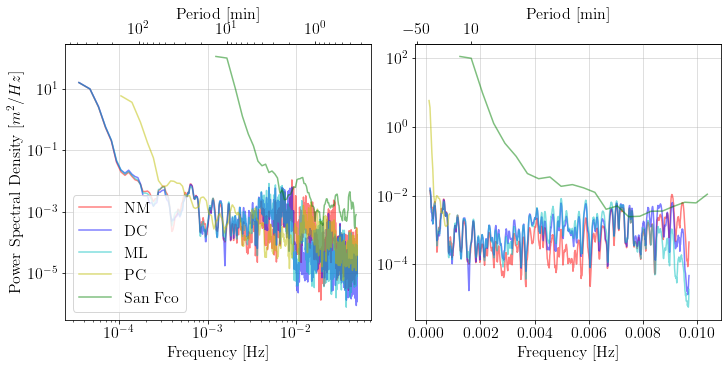

In [26]:
h_dc = dc1['Depth'] - dc1['Depth'].mean()
h_ml = ml1['Depth'] - ml1['Depth'].mean()
h_nm = nm1['Depth'] - nm1['Depth'].mean()
h_pc = pc1['Depth'] - pc1['Depth'].mean()
h_sf = sf['Verified (m)'] - sf['Verified (m)'].mean()
    
freqs1, ps1, psd1 = spectrum4(h_nm, dt=10)
freqs2, ps2, psd2 = spectrum4(h_dc, dt=10)
freqs3, ps3, psd3 = spectrum4(h_sf, dt=10)
freqs4, ps4, psd4 = spectrum4(h_ml, dt=10)
freqs5, ps5, psd5 = spectrum4(h_pc, dt=10)

fig, axs = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
axs[0].loglog(freqs1, psd1, 'r', alpha=0.5, label='NM')
axs[0].loglog(freqs2, psd2, 'b', alpha=0.5, label='DC')
axs[0].loglog(freqs4, psd4, 'c', alpha=0.5, label='ML')
axs[0].loglog(freqs5, psd5, 'y', alpha=0.5, label='PC')
axs[0].loglog(freqs3, psd3, 'g', alpha=0.5, label='San Fco')
# axs[0].axis('tight', which='x')
axs[0].legend(loc='lower left',
          fontsize=16)

i0, i1 = np.searchsorted(freqs1, [1.31969058e-04, 9.70464135e-03])
i04, i14 = np.searchsorted(freqs2, [0.31969058e-04, 3e-04])
sl = slice(i0, i1)
sl4 = slice(i04, i14)
axs[1].semilogy(freqs1[sl], psd1[sl], 'r', 
              freqs2[sl], psd2[sl], 'b', 
              freqs4[sl], psd4[sl], 'c', 
              freqs5[sl4], psd5[sl4], 'y', 
              freqs3[sl4], psd3[sl4], 'g', alpha=0.5)
#axs[1].axis('tight', which='x')
axs[0].set_ylabel('Power Spectral Density [$m^2/Hz$]',
          fontsize=16)
axs[0].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[1].set_xlabel('Frequency [Hz]',
          fontsize=16)
axs[0].xaxis.set_tick_params(labelsize=16)
axs[0].yaxis.set_tick_params(labelsize=16)
axs[1].xaxis.set_tick_params(labelsize=16)
axs[1].yaxis.set_tick_params(labelsize=16)
axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)


def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

secax0 = axs[0].secondary_xaxis('top', functions=(freq2period, period2freq))
secax0.set_xlabel('Period [min]',
          fontsize=16)
secax1 = axs[1].secondary_xaxis('top', functions=(freq2period, period2freq))
secax1.set_xlabel('Period [min]',
          fontsize=16)
secax0.xaxis.set_tick_params(labelsize=16)
secax0.yaxis.set_tick_params(labelsize=16)
secax1.xaxis.set_tick_params(labelsize=16)
secax1.yaxis.set_tick_params(labelsize=16)
secax0.grid(alpha=0.5)
secax1.grid(alpha=0.5)

plt.show()

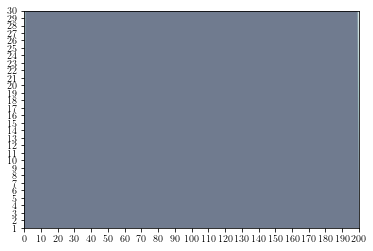

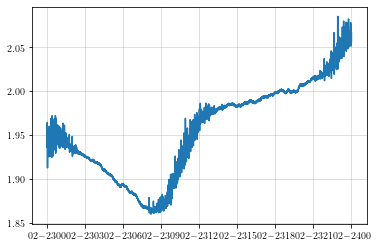

In [32]:
# t = dc1.index
# sig  = dc1['Depth'].values
# widths = np.arange(1,31)
# coef,freqs = signal.cwt(t, sig, signal.ricker, widths)
# plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
#            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
# plt.show()

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef,freqs = pywt.cwt(sig, widths, 'gaus1')
plt.figure()
plt.imshow(abs(coef), extent=[0, 200, 30, 1], interpolation = 'bilinear', cmap='bone', aspect='auto',
           vmax=abs(coef).max(), vmin=-abs(coef).max())
plt.gca().invert_yaxis()
plt.yticks(np.arange(1,31,1))
plt.xticks(np.arange(0,201,10))
plt.show

plt.figure()
plt.plot(t,sig)
plt.grid(alpha=0.5)

